<a href="https://colab.research.google.com/github/ibenoam/Neural_cryptography/blob/main/Neural_Cryptography_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural-Cryptography
## Solving the key exchange problem by neural-networks synchronization

**Introduction**<br>
In cryptography, one of the main problems is the key-exchange-problem. Two parties, Alice and Bob, want to exchange a private key over a public channel. It has been solved by the famous Diffie-Helman protocol in 1976. The fact that this problem is considered as solved does not prevent us to think about different creative ideas, like using "black-box" algorithms like neural-networks to solve this problem. I will present a scheme of a protocol which utilizing neural-network synchronization for creating a private key. This protocol is based on my master advisor's paper: ["Interacting Neural Networks and Cryptography"](https://link.springer.com/chapter/10.1007/3-540-45618-X_30)

**The architecture** <br>The neural network architecture we use is called Tree-Parity-Machines (TPMs). Each TPM has only one hidden layer which consists of K nodes, where each node is connected to N different entries from the input layer.
The architecture (with K=3) is presented in the following figure:

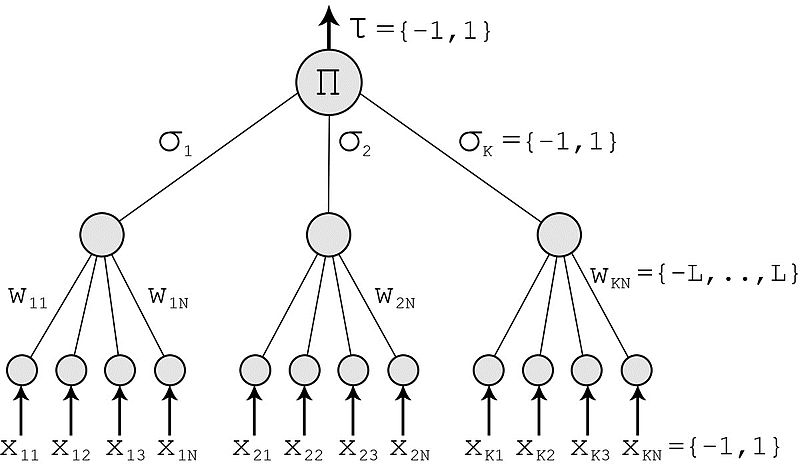

Each hidden node's value, noted by sigma, is calculated as:<br>
$$\sigma_i = sign (\sum_{j=1}^N W_{ij} \cdot x_{ij}) $$
where the inputs consist of plus-minus ones, and the weights are integers between –L to L, Where L is called “the synaptic depth”.<br>
$$x_{ij} \in\{-1, 1\},\quad W_{ij}\in\{-L, -L+1, ..., 0, ..., L-1, L\}$$
Then, the output is calculated by:<br>
$$\tau = \prod_{j=1}^K \sigma_i $$

**The Hebbian theory**<br>
Usually, people who are familiar with neural networks, think automatically on gradient-descent algorithm for updating the weights. If we take a step-back in the history, there were other options for learning algorithms, such as hebbian learning rule. 
The Hebbian Theory is a theory from neuroscience. It was introduced by a Canadian psychologist named Donald Hebb in 1949. The theory describes a basic mechanism for synaptic plasticity in the brain. The theory is often summarized as "Cells that *fire together wire together*." We will use this rule for updating the weights as follows:<br>
$$W^{new} = W^{old} + input ⋅ output $$

**The process**<br>
First, each of Alice & Bob initialize his own TPM with randomly chosen weights. Then, they recieve common input vector, each calculates his output and sends it to the other. Only when the outputs are identical- they update the weights according to the Hebbian learning rule (with boundaries). They repeat this process until their TPMs are synchronized, means, Alice's TPM weights are *identical* to the Bob's TPM weights.


**An attack with a single TPM**<br>
Eve wants to eavesdrop to the communication between Alice and Bob. We assume that Eve knows the chosen architecture, the chosen learning rule, the input vectors and the outputs of Alice's and Bob's TPM(!). She wants to find with Alice's TPM weights before the synchronization process between Alice and Bob is finished. If she can create only one TPM, *what can she do?*<br><br>
**The naive approach**<br>
Eve initializes her own TPM with random weights.<br>
Then, she updates her TPM weights according to the learning rule excatly like if Alice would try to synchronize with her.<br>
To understand why this approach does not work, we need to understand the diffence between Eve and Bob. Alice and Bob updating their TPMs only when their outputs are the same, means that in the case when:<br>
$$\tau^{Eve} \not= \tau^{Alice} = \tau^{Bob} $$
Alice and Bob will update their weights, but Eve does not know how to take a step!<br> The main difference between Bob and Eve is that Bob can *affect* the synchronization process and Eve cannot!<br><br>

**The best attack strategy using only a single TPM**<br>
When the case that I mention happens, Eve does as follows. she looks for the most "insecure" perceptron and flips its output. She can find it according to the fields (the values after summation, before the sign function), the hidden node with the minimal absolute field. and flips its output. After the flipping, her output is now identical to Alice's output and she can update the weights according to the learning rule as before.


## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy

## TPM Class

Lets define our Tree-Parity Machine (TPM) class:

In [4]:
class TPM:
    def __init__(self,N,K,L,M=1):
        # Constants:
        self.N = N
        self.K = K
        self.L = L
        self.M = M

        # Initialization:
        self.w = np.floor((2*L+1) * np.random.rand(N,K)) - L
        self.init_w = copy.deepcopy(self.w)
        self.fields = np.zeros((1,K))
        self.sigmas = np.zeros((1,K))
        self.tau = 0

    # The feed-forward:
    def forward(self,input):
        self.fields = np.sum(self.w*input, axis=0)
        self.sigmas = np.sign(self.fields + 1e-10)
        # I add 1e-10 to get sigmas != 0
        self.tau = np.prod(self.sigmas)
  
    # updating the weights:
    def update(self,input):
        update_indexes = np.where(self.sigmas == self.tau)
        self.w[:,update_indexes] += input[:,update_indexes]
        self.w[np.abs(self.w)>self.L] = np.sign(self.w[np.abs(self.w)>self.L])*self.L

    # "correlation" calculates the correlation between two sets of weights (the cosinus).
    def correlation(self, other):
        w1 = np.transpose(self.w.flatten())
        w2 = other.w.flatten()
        corr_val = (w1 @ w2) / (np.linalg.norm(w1) * np.linalg.norm(w2))
        return corr_val

    # "self_correlation" is similar to "correlation" except that it calculates
    # the correlation between the current weights and the initial weights.
    def self_correlation(self):
        w1 = np.transpose(self.w.flatten())
        w2 = self.init_w.flatten()
        corr_val = (w1 @ w2) / (np.linalg.norm(w1) * np.linalg.norm(w2))
        return corr_val

## Main

Now, we define a few constants and initialize a dictionary named 'data' which has the following keys:
*   'sync_time': number of steps until Alice and Bob succeed to converge.
*   'attacker_time': number of steps Eve needed until convergence to Alice's weights.
*   'corr_alice'/('corr_bob'): the correlation between Alice's/(Bob's) final weights and the initial weights.
*   'corr_alice_bob': the correlation over time between Alice and Bob weights.
*   'corr_alice_eve': the correlation over time between Alice and Eve weights.


In [5]:
N = 10 # each N input neurons are connected to 1 hidden neuron
L = 3 # the "synaptic" depth
K = 3 # number of perceptrons (or the hidden layer size)
M = 1 # the input consists of integers in the range [-M,M] without 0

num_sys = 100 # we average each result "num_sys" times

data = {'sync_time': [], 'attacker_time': [], 'corr_alice': [], 'corr_bob': [], 'corr_alice_bob':  [[] for _ in range(num_sys)],
        'corr_alice_eve':  [[] for _ in range(num_sys)], 'when_move': [[] for _ in range(num_sys)]}

In [6]:
for i in range(num_sys):
    # Generate Alice's and Bob's TPMs:
    alice = TPM(N,K,L)
    bob = TPM(N,K,L)
    # Generates the attacker's TPM:
    eve = TPM(N,K,L)

    count_steps = 0
    flag = True # True means that alice's TPM and Bob's TPM are not the same

    while not np.array_equal(alice.w,eve.w):
        # print(f"After {count_steps} steps.")
        count_steps += 1
        if flag:
            data['corr_alice_bob'][i].append(alice.correlation(bob))
            data['corr_alice_eve'][i].append(alice.correlation(eve))

            if np.array_equal(alice.w,bob.w): # and flag
                data['sync_time'].append(count_steps)
                data['corr_alice'].append(alice.self_correlation())
                data['corr_bob'].append(bob.self_correlation())
                flag = False

        inputs = np.sign(np.random.rand(N,K)-0.5)
        # for more general case:
        # inputs = (np.random.randint(M,size=(N,K))+1)*(np.sign(np.random.rand(N,K)-0.5))
        alice.forward(inputs)
        bob.forward(inputs)
  
        # According to the algorithm, Alice and Bob take a step only when their outputs are identical:
        if alice.tau == bob.tau:
            data['when_move'][i].append(1)
            alice.update(inputs)
            bob.update(inputs)
        else:
            data['when_move'][i].append(0)
      
        # The best strategy for an attacker with only a single TPM:
        eve.forward(inputs)
        if eve.tau == alice.tau:
            eve.update(inputs)
        else:
            min_field_index = np.argmin(np.abs(eve.fields))
            eve.sigmas[min_field_index] *= -1 # flips a field
            eve.tau *= -1 # which flips the output
            eve.update(inputs)
        # data['corr_alice_eve'][i].append(alice.correlation(eve))

    # print(f" finished {100*(i+1)/num_sys}% of the runtime")
    data['attacker_time'].append(count_steps)

In [7]:
print(f" The average synchronization time between Alice and bob is {np.mean(data['sync_time']):.3f} steps with std of {np.std(data['sync_time']):.3f}")
print(f" The average learning time between of Eve is {np.mean(data['attacker_time']):.3f} steps with std of {np.std(data['attacker_time']):.3f}")

 The average synchronization time between Alice and bob is 222.550 steps with std of 87.284
 The average learning time between of Eve is 694.390 steps with std of 420.630


# Figures

We want to see whether Alice and Bob succeeded to sychronize and how much time it took for them. 

## Fig. 1: histogram of the synchronization time between Alice and bob

[]

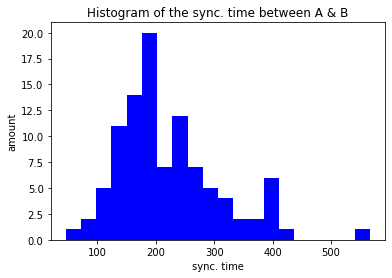

In [8]:
plt.figure()
plt.hist(data['sync_time'], color = "blue", bins = 20)
plt.title('Histogram of the sync. time between A & B')
plt.xlabel("sync. time")
plt.ylabel("amount")
plt.plot()

As you can see, Alice's TPM succeeds to synchronize with Bob's TPM every time! It is not that surprising since it has been proven analytically that this mutual learning process, under the restriction of discrete weights, takes a finite number of steps in [this](https://iopscience.iop.org/article/10.1088/0305-4470/35/47/104/meta) paper.

We want to see whether Eve does not succeed to converge faster than Alice and Bob.

## Fig. 2: histogram of Eve's learning time

[]

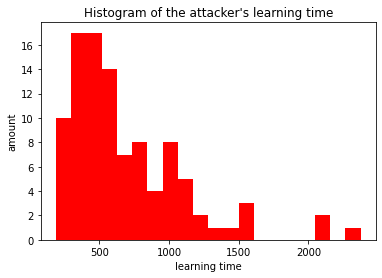

In [9]:
plt.hist(data['attacker_time'], color = "red",  bins = 20)
plt.title("Histogram of the attacker's learning time")
plt.xlabel("learning time")
plt.ylabel("amount")
plt.plot(c = 'red')

As we can see, in average Eve's learning time is greater than the synchronization time between Alice and Bob. **But** we want to know if there is a chance that Eve's time is better! so...

## Fig. 3: The ratio between Eve's learning time and the synchronization time

 The average ratio between the attacker learning time and the synchronization time is 3.429 with std of 2.331
 The minimal ratio  is 1.051


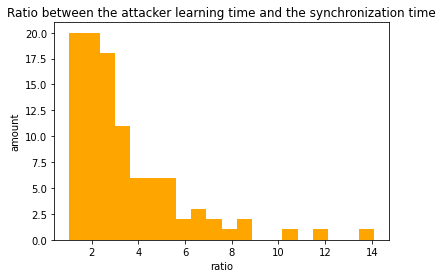

In [10]:
ratio_attack_sync = [i/j for i, j in zip(data['attacker_time'], data['sync_time'])]
data['ratio_attack_sync'] = ratio_attack_sync

plt.figure()
plt.hist(ratio_attack_sync, color = "orange", bins = 20)
plt.title('Ratio between the attacker learning time and the synchronization time')
plt.xlabel("ratio")
plt.ylabel("amount")
plt.plot()

print(f" The average ratio between the attacker learning time and the synchronization time is {np.mean(ratio_attack_sync):.3f} with std of {np.std(ratio_attack_sync):.3f}")
print(f" The minimal ratio  is {np.min(ratio_attack_sync):.3f}")

As we can see, the minimal ratio is always greater than 1, which means that Alice and Bob succeed to synchronize before Eve.

## Fig. 4: Histogram of the correlation between Alice's initial weights and her final weights

One can say that if we know Alice's weights initial state, we can evaluate where she will end.
<br> Therefore, we calculate the correlation between Alice's initial and her final weights:

 The average correlation between Alice's initial and final weights is -0.017 steps with std of 0.191


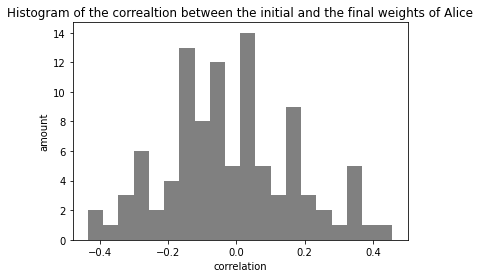

In [11]:
plt.figure()
plt.hist(data['corr_alice'], color = "grey", bins = 20)
plt.title('Histogram of the correaltion between the initial and the final weights of Alice')
plt.xlabel("correlation")
plt.ylabel("amount")
plt.plot()

print(f" The average correlation between Alice's initial and final weights is {np.mean(data['corr_alice']):.3f} steps with std of {np.std(data['corr_alice']):.3f}")

As we can see, the histogram is around zero (0= no correlation at all).

## Fig. 5: The weights correlation over time

The following graph shows that correlation between Alice's TPM and Bob's TPM increases faster than the correlation between Alice's TPM and Eve's TPM over the learning steps:

[Text(0.5, 0, 'time')]

<Figure size 432x288 with 0 Axes>

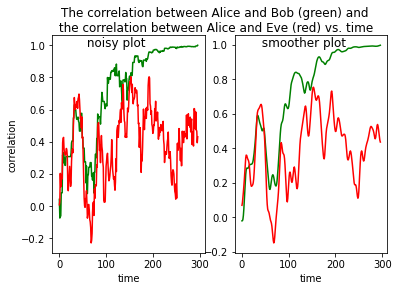

In [31]:
from scipy.ndimage.filters import gaussian_filter1d

which_sys=0

fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('The correlation between Alice and Bob (green) and\n the correlation between Alice and Eve (red) vs. time\n noisy plot                              smoother plot')
ax1.plot(range(len(data['corr_alice_bob'][which_sys])), data['corr_alice_bob'][which_sys], c = 'green')
ax1.plot(range(len(data['corr_alice_eve'][which_sys])), data['corr_alice_eve'][which_sys], c = 'red')
ax1.set(xlabel='time', ylabel='correlation')
# ax1.set_title('noisy plot')
ax2.plot(range(len(data['corr_alice_bob'][which_sys])), gaussian_filter1d(data['corr_alice_bob'][which_sys],2), c = 'green')
ax2.plot(range(len(data['corr_alice_eve'][which_sys])), gaussian_filter1d(data['corr_alice_eve'][which_sys],2), c = 'red')
ax2.set(xlabel='time') #, ylabel='correlation')
# ax2.set_title('smoother plot')

As you can see, the correlation between Alice and Bob rises more monotonically where the correlation with Eve suffers from a noise because of her strategy.

## Fig. 6: The probability to get the identical outputs over time

The following figure confirms the assumption that as the correlation between Alice's and Bob's weights higher, it is more likely to get the same output.

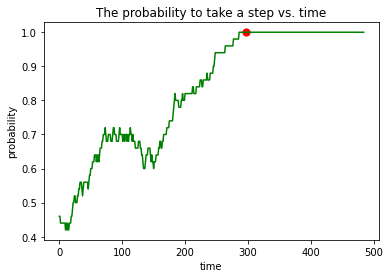

In [35]:
# sliding window
window_size = 50
chance = []
for i in range(len(data['when_move'][0])-window_size+1):
    chance.append(sum(data['when_move'][0][i:i + window_size])/window_size)

plt.figure()
plt.title('The probability to take a step vs. time')
plt.xlabel("time")
plt.ylabel("probability")
plt.plot(range(len(chance)), chance, c = 'green')
plt.scatter(int(data['sync_time'][0]), chance[int(data['sync_time'][0])], c = 'red', s = 10, linewidth = 5)

**Conclusion**<br>
We saw how two neural networks can synchronize their weights in order to create a secret key over a public channel. In addition, we implemented the best possible attack using only one TPM, and compared the synchronization time between Alice and Bob to the learning time of Eve. Off course, there are better attacks using many TPMs, but lets keep it for future posts :)
<br><br>
There are a lot more to be disscused, like what happens where the weights are continuos, what about "man in the middle", and so on.
You do not often see these two fields of cryptography and neural-networks meet each other, where the former is very rigorous with many mathematical proofs, and the latter is kind of a black box.<br><br>
Finally, there are a lot of published scientific-papers that worth more exposure. Apparently, because of the new papers publishing rate, where each one improves a little the previous state-of-the-art result, we are missing a lot of creative ideas that may not change the world by themself, but could stand as a spike to various ideas. I hope you will find this article as an inspiration for outside the box thinking.